# Fanbeam in 2D (fanflat) reconstruction from numerical phantom
In this notebook we study the effect of reconstruction of the fanbeam approximation in SART.
The approximation is the following: if you make a simple 2D reconstruction of the bubble
in a horizontal slice in the reactor, and the X-ray tube is _not exactly opposing the detector_ 
in that slice, the detector values that are used are slightly wrong. Namely, the detector pixels measure 
the ray-path from source to detector, and the rays came under an angle, they didn't go exactly 
through that horizontal slice of interest. So it is expected that there is an error that
scales with the distance deviation from the actual source-detector-plane.

Here we take a bubble phantom which we send through the column. The bubble is a bit compressed in the z-direction, but a perfect circle in the x-y plane. This is so that its easier to recognize in which view you are. The bubble is also a bit off the center, so that we can study the approximation effects better.


In [1]:
from fbrct import *
from fbrct.phantom import *
from fbrct.util import *
import matplotlib.pyplot as plt

In [2]:
apart, dpart = uniform_angle_partition(), detector_partition_2d()
geometry = odl.tomo.FanFlatGeometry(apart, dpart, SOURCE_RADIUS, DETECTOR_RADIUS)

recon_height = int(DETECTOR_ROWS/2)

n = 100  # amount of voxels in one dimension (i.e. nxn object)
L = 10  # centimeters  -L cm to L cm in the physical space

# We're building the linear X-Ray operator that artificially projects
# the bubble reactor onto the detector
reco_space = odl.uniform_discr(
    min_pt=[-L, -L],
    max_pt=[L, L],
    shape=[n, n])
xray_transform = odl.tomo.RayTransform(reco_space, geometry)

In [25]:
# we need a 3D geometry to simulate projection (detector) data
dpart_3d = detector_partition_3d(DETECTOR_ROWS)
phantom_geometry = odl.tomo.ConeFlatGeometry(apart, dpart_3d, SOURCE_RADIUS, DETECTOR_RADIUS)
p = generate_3d_phantom_data(PHANTOM_3D_SIMPLE_ELLIPSOID, L, L, n, n, phantom_geometry)

## Central slice experiment
All the detectors see a fine bubble. The bubble is going through the slice when time progresses.

At time 0 the bubble is in the center of the column.


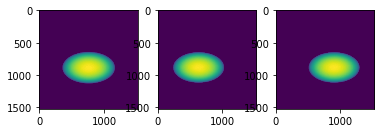

At time 20 it has gone through the slice that is at height around 700, and arrives at 500 or so.


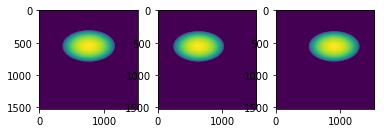

In [50]:
print("At time 0 the bubble is in the center of the column.")
plot_sino(p[0, :, :, :])
print("At time 20 it has gone through the slice that is at height around 700, and arrives at 500 or so.")
plot_sino(p[20, :, :, :])

Here we get an elementary reconstruction, we do 150 iterations SART. The result is okay, shows a good bubble, but still has some lines due to the limited angles.

Reconstruction at t= 0


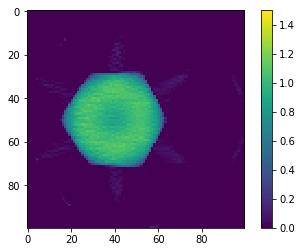

Reconstruction at t= 7


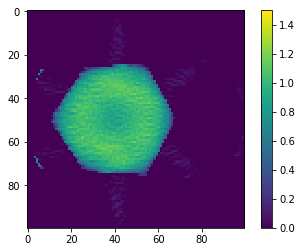

Reconstruction at t= 14


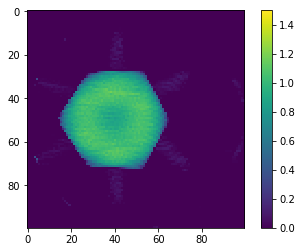

Reconstruction at t= 21


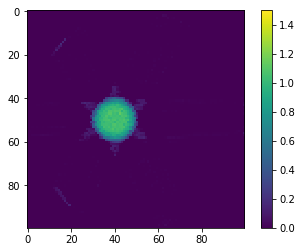

In [64]:
for t in range(0,25,7):
    print("Reconstruction at t=", t)
    h = recon_height
    # take and scale the projection data
    sinogram = p[t, :, :, h]

    # reconstruct iteratively
    # starting vector is 0 in iteration
    x = xray_transform.domain.element(
        np.zeros(xray_transform.domain.shape))

    # we start by doing some SART iterations
    reconstruct_filter(
        xray_transform,
        sinogram,
        x,
        niter=150,
        clip=(0, None),  # clipping values
        mask=circle_mask_2d(x.shape)
    )

    # plot results
    plt.figure(h)
    plt.clf()
    plt.imshow(x, vmax=1.5)
    plt.colorbar()
    plt.pause(.1)

# Noncentral slice experiment

Now we try to make the reconstruction at a noncentral height on the detector, so that there is a manifest of the fanbeam-approximation. Of course we could crank up the iterations/smooth out the artifacts, but the point is to show that the error is there, and what it looks like.

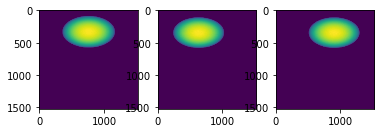

In [73]:
plot_sino(p[33, :, :, :])

Reconstruction at t= 30


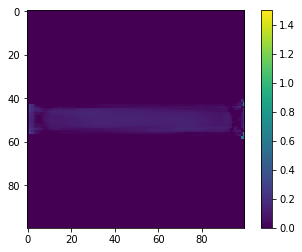

Reconstruction at t= 31


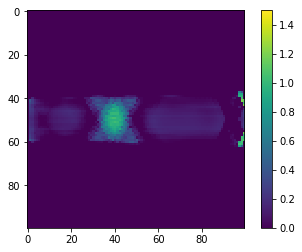

Reconstruction at t= 32


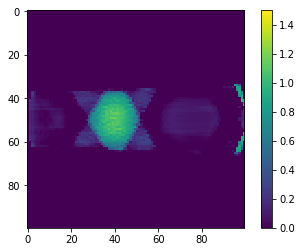

Reconstruction at t= 33


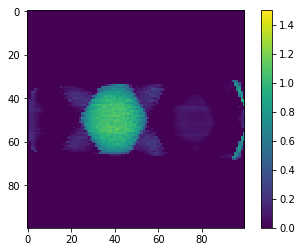

In [74]:
for t in range(30,34,1):
    print("Reconstruction at t=", t)
    h = 150 
    # take and scale the projection data
    sinogram = p[t, :, :, h]

    # reconstruct iteratively
    # starting vector is 0 in iteration
    x = xray_transform.domain.element(
        np.zeros(xray_transform.domain.shape))

    reconstruct_filter(
        xray_transform,
        sinogram,
        x,
        niter=150,
        clip=(0, None),  # clipping values
        # fn_filter=lambda u: .1 * medians_2d(u) + .9 * u,  # median filter
        mask=circle_mask_2d(x.shape)
    )

    # plot results
    plt.figure(h)
    plt.clf()
    plt.imshow(x, vmax=1.5)
    plt.colorbar()
    plt.pause(0.1)

At timestep $t=30$ the bubble is appearing on one of the detectors just a bit earlier than the others, because it is a bit more closer to one of the three detectors. Because of the imbalance we also spot a trace of the beam in later reconstructions because the pixels cannot be explained as accurately.

Note this all is very much a quantitative study, by changing reconstruction methods (amount of iterations, types of filtering) the approximation could manifest itself in a different way.